In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorched.step_by_step import StepByStep, RUNS_FOLDER_NAME
import platform

import datetime
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
plt.style.use('fivethirtyeight')

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

%load_ext autoreload
%autoreload 2

# Binary Classification

We'll use Scikit-Learn’s make_moons to generate a toy dataset with 1000 data points and two features.

## Data Generation

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.3, random_state=11)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

We first use Scikit-Learn's `StandardScaler` to standardize datasets:

In [ ]:
sc = StandardScaler()
sc.fit(X_train)  # always fit only on X_train
X_train_scalled = sc.transform(X_train)
X_val_scalled = sc.transform(X_val)  # DO NOT use fit or fit_transform on X_val, it causes data leak
m = sc.mean_
v = sc.var_
print(m, v)
assert ((X_train_scalled[0] - m)/np.sqrt(v) - X_train[0] < np.finfo(float).eps).all()

[0.4866699  0.26184213] [0.80645937 0.32738853]


In [ ]:
X_train = X_train_scalled
X_val = X_val_scalled

In [ ]:
from matplotlib.colors import ListedColormap

def figure1(X_train, y_train, X_val, y_val, cm_bright=None):
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)#, edgecolors='k')
    ax[0].set_xlabel(r'$X_1$')
    ax[0].set_ylabel(r'$X_2$')
    ax[0].set_xlim([-2.3, 2.3])
    ax[0].set_ylim([-2.3, 2.3])
    ax[0].set_title('Generated Data - Train')

    ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright)#, edgecolors='k')
    ax[1].set_xlabel(r'$X_1$')
    ax[1].set_ylabel(r'$X_2$')
    ax[1].set_xlim([-2.3, 2.3])
    ax[1].set_ylim([-2.3, 2.3])
    ax[1].set_title('Generated Data - Validation')
    fig.tight_layout()
    
    return fig

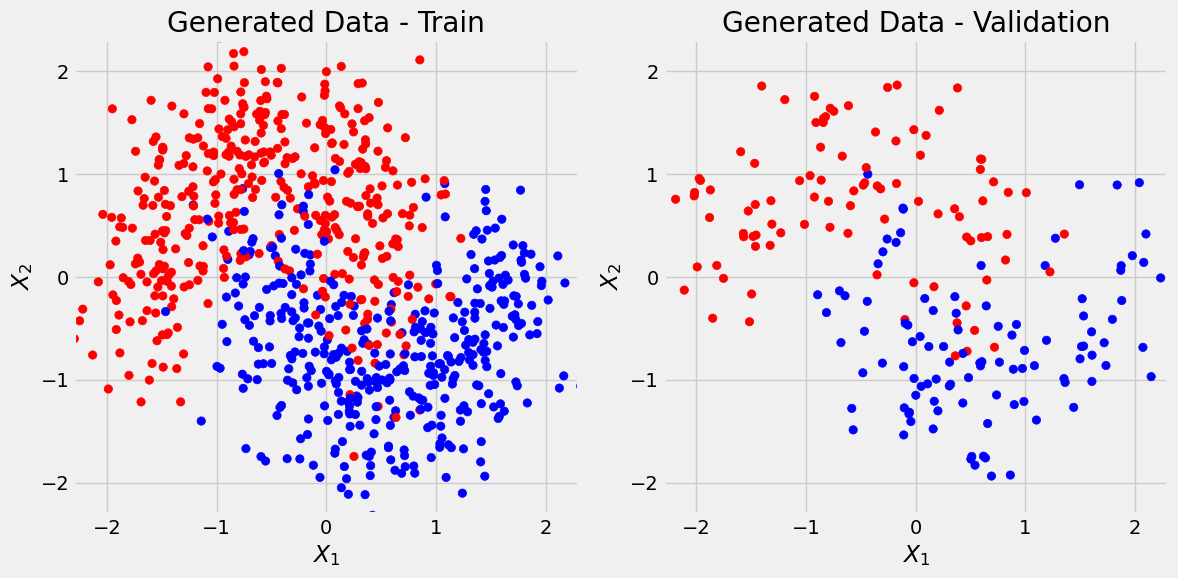

In [ ]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

The preparation of data starts by **converting the data points** from Numpy arrays to PyTorch tensors and sending them to the available **device**:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()  # reshape makes shape from (80,) to (80,1)

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

In [ ]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
val_data = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, 64, shuffle=True)
val_loader = DataLoader(val_data, 64)

## Linear model

In [ ]:
torch.manual_seed(42)

lr = 0.01

model = nn.Sequential()
model.add_module('linear', nn.Linear(2,1))
model.add_module('sigmoid', nn.Sigmoid())

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [ ]:
sbs_lin = StepByStep(model, optimizer, loss_fn)
sbs_lin.set_loaders(train_loader, val_loader)
sbs_lin.train(100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.69it/s]


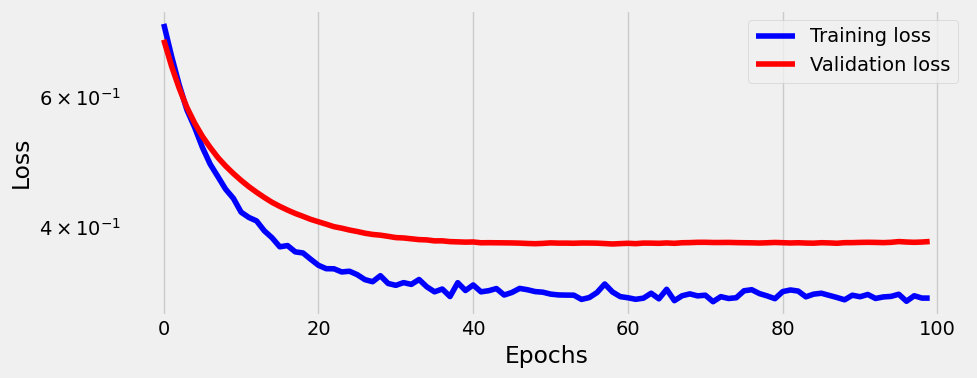

In [ ]:
_ = sbs_lin.plot_losses()

Let's predict the values for `X_train` (`y_train_predicted`) and `X_val` (`y_val_predicted`) and plot them. Also let's see how good of a job linear regression did using confusion matrix:

In [ ]:
def predict_plot_count(sbs):
    y_train_predicted = sbs.predict(X_train)
    y_val_predicted = sbs.predict(X_val)
    fig = figure1(X_train, y_train_predicted, X_val, y_val_predicted)
    print('Confusion matrix:')
    print(confusion_matrix(y_val, list(map(int, (y_val_predicted > 0.5).ravel()))))
    print('Correct categories:')
    print(sbs.loader_apply(sbs.val_loader, sbs.correct))

Confusion matrix:
[[82 14]
 [14 90]]
Correct categories:
tensor([[ 82,  96],
        [ 90, 104]])


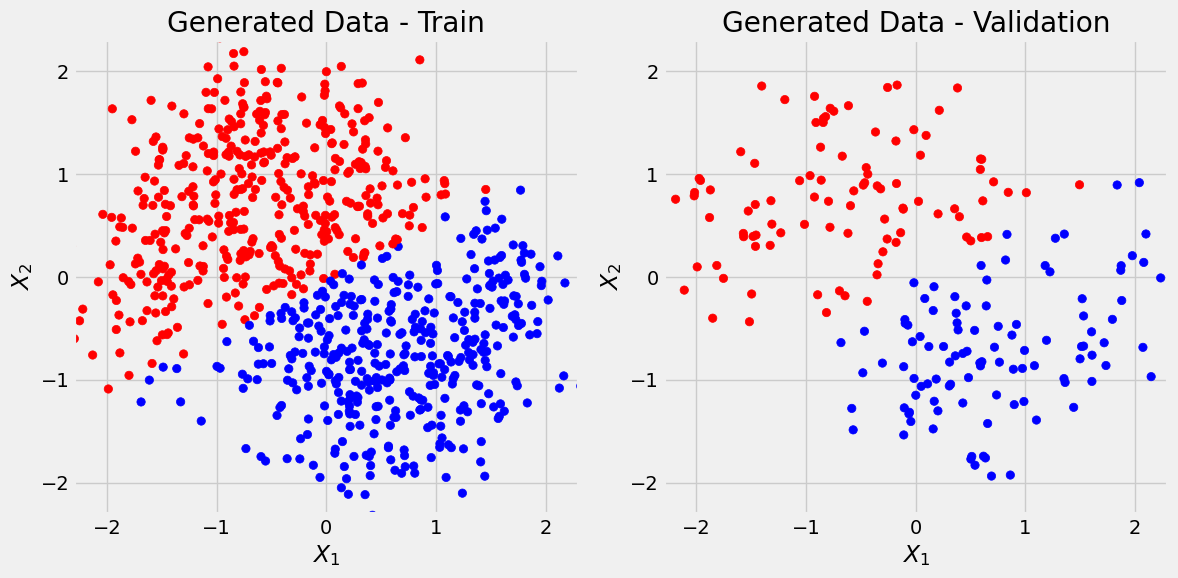

In [ ]:
predict_plot_count(sbs_lin)

and we see there are some false positives and false negatives (off-diagonal elements).

## Two-layer model

Let's make a better model.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.74it/s]


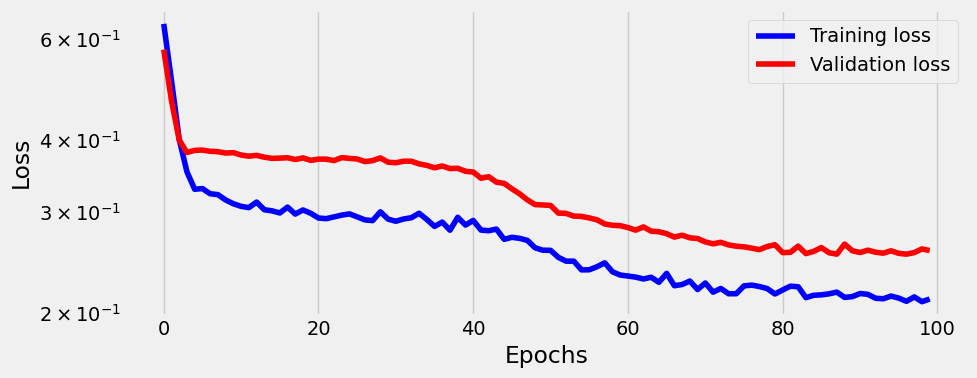

In [ ]:
model_nonlin = nn.Sequential()
model_nonlin.add_module('linear1', nn.Linear(2,10))
model_nonlin.add_module('relu', nn.ReLU())
model_nonlin.add_module('linear2', nn.Linear(10,1))
model_nonlin.add_module('sigmoid', nn.Sigmoid())
optimizer = optim.Adam(model_nonlin.parameters(), lr=lr)

sbs_nonlin = StepByStep(model_nonlin, optimizer, loss_fn)
sbs_nonlin.set_loaders(train_loader, val_loader)
sbs_nonlin.train(100)
_ = sbs_nonlin.plot_losses()

Confusion matrix:
[[86 10]
 [10 94]]
Correct categories:
tensor([[ 86,  96],
        [ 94, 104]])


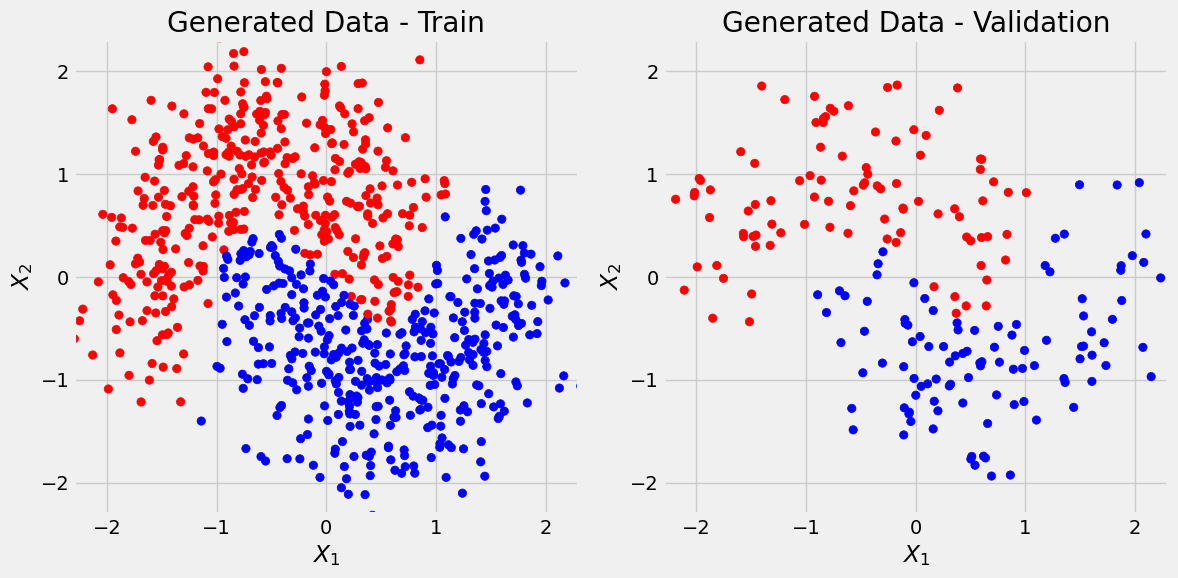

In [ ]:
predict_plot_count(sbs_nonlin)

And this is better (we could calculate precision and recall).

# Three-layer model

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 45.80it/s]


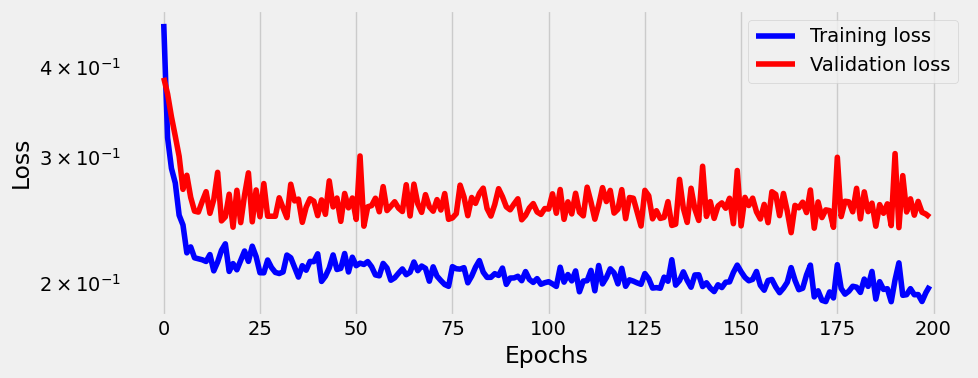

In [ ]:
model_nonlin2 = nn.Sequential(
    nn.Linear(2,50),
    nn.ReLU(),
    nn.Linear(50,20),
    nn.ReLU(),
    nn.Linear(20,1),
    nn.Sigmoid()
    )
optimizer = optim.Adam(model_nonlin2.parameters(), lr=lr)

sbs_nonlin2 = StepByStep(model_nonlin2, optimizer, loss_fn)
sbs_nonlin2.set_loaders(train_loader, val_loader)
sbs_nonlin2.train(200)
_ = sbs_nonlin2.plot_losses()

Confusion matrix:
[[86 10]
 [11 93]]
Correct categories:
tensor([[ 86,  96],
        [ 93, 104]])


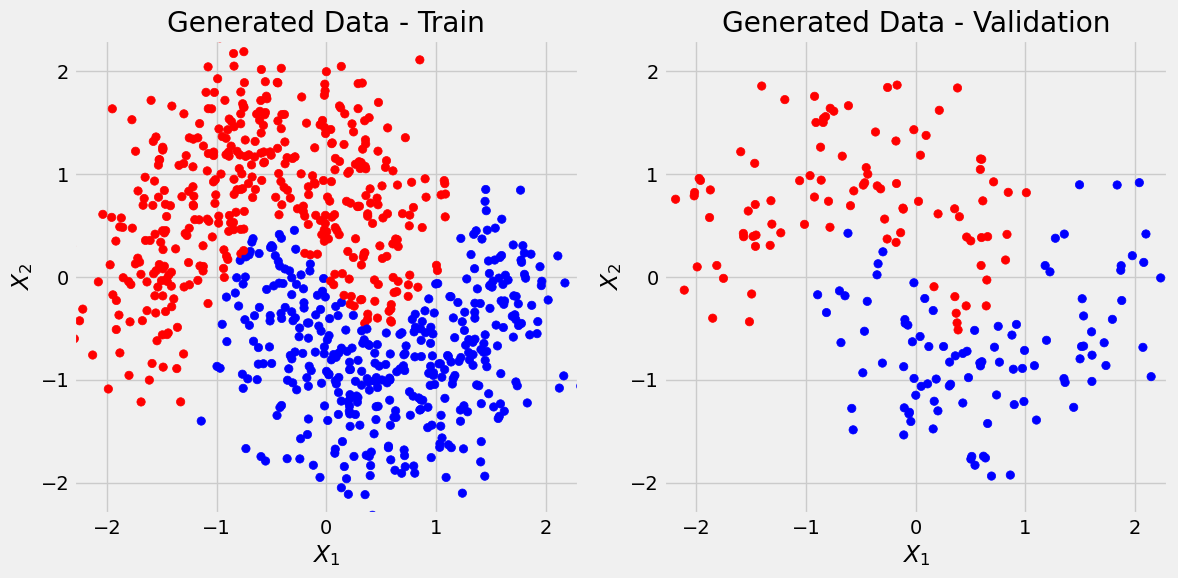

In [ ]:
predict_plot_count(sbs_nonlin2)

Not much better then 2-layer model, and we can see that model might be overfitting considering flattness of `val_loss`. But overall not bad considering the noise.

# Trying SGD instead of Adam

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.42it/s]


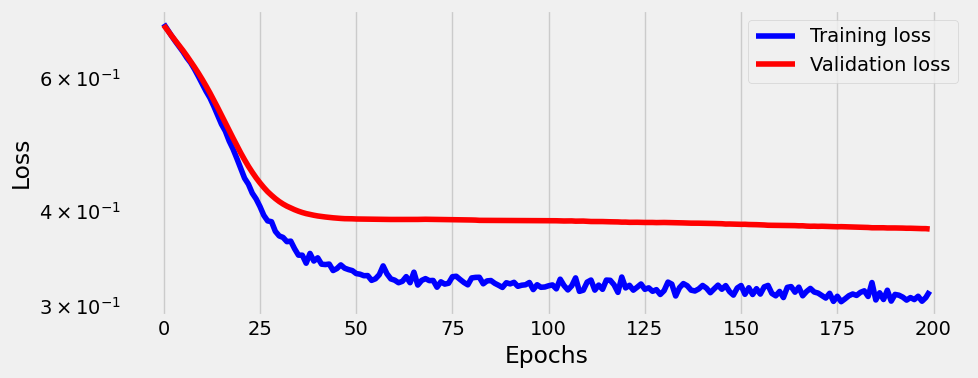

In [ ]:
model_nonlin2 = nn.Sequential(
    nn.Linear(2,50),
    nn.ReLU(),
    nn.Linear(50,20),
    nn.ReLU(),
    nn.Linear(20,1),
    nn.Sigmoid()
    )
optimizer = optim.SGD(model_nonlin2.parameters(), lr=lr)

sbs_nonlin3 = StepByStep(model_nonlin2, optimizer, loss_fn)
sbs_nonlin3.set_loaders(train_loader, val_loader)
sbs_nonlin3.train(200)
_ = sbs_nonlin3.plot_losses()

Confusion matrix:
[[83 13]
 [13 91]]
Correct categories:
tensor([[ 83,  96],
        [ 91, 104]])


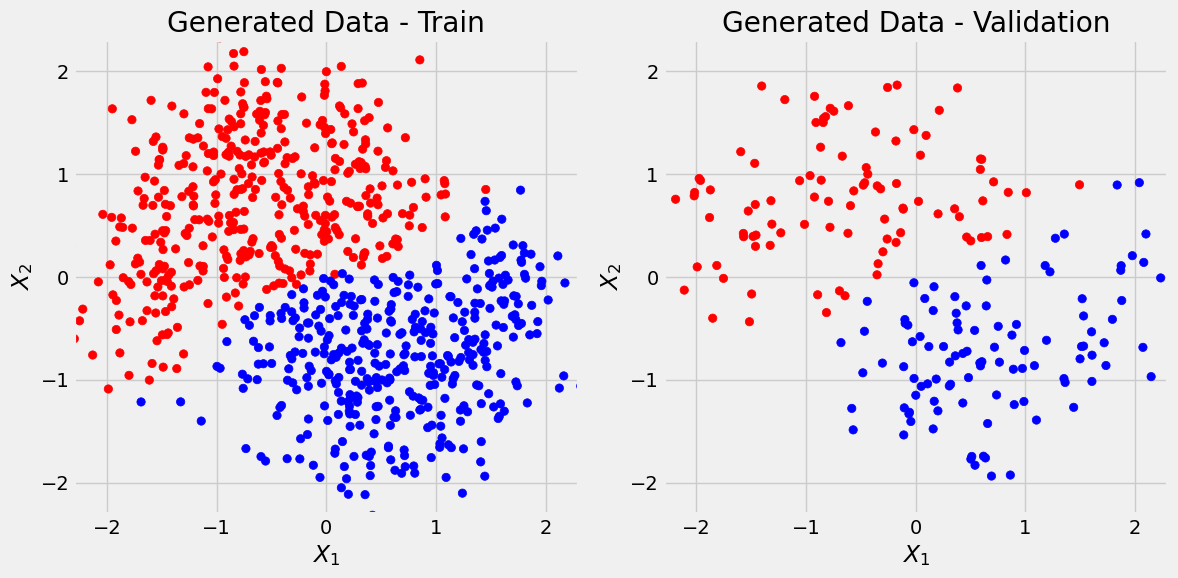

In [ ]:
predict_plot_count(sbs_nonlin3)

So Adam optimizer is performing much better then SGD.